In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split
import pickle
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [ ]:
# XOR Dataset
X = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
y = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)

# Model 1

In [ ]:
# XOR Dataset
X = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
y = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)

# Create DataLoader for batch processing
dataset = TensorDataset(X, y)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Define the Recurrent Neural Network
class XOR_RNN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=4, output_dim=1):
        super(XOR_RNN, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence dimension: [batch_size, seq_len=1, input_dim]
        rnn_out, _ = self.rnn(x)  # rnn_out: [batch_size, seq_len, hidden_dim]
        last_hidden = rnn_out[:, -1, :]  # Get the last hidden state: [batch_size, hidden_dim]
        output = torch.sigmoid(self.fc(last_hidden))  # Sigmoid activation for binary output
        return output

# Initialize the model, loss, and optimizer
model = XOR_RNN()
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
epochs = 5000
trained_metrics = {'losses': [], 'accuracies': []}  # To store loss and accuracy
weights_and_biases_history = []  # To store weights and biases


## Model training

In [ ]:

# Training loop
for epoch in range(epochs):
    epoch_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in data_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()

        # Calculate accuracy
        predicted = (outputs > 0.5).float()
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

    # Calculate epoch metrics
    avg_loss = epoch_loss / len(data_loader)
    accuracy = 100 * correct / total
    trained_metrics['losses'].append(avg_loss)
    trained_metrics['accuracies'].append(accuracy)

    # Save weights and biases for this epoch
    epoch_weights_and_biases = {
        'rnn_weight': model.rnn.weight_hh_l0.detach().numpy(),
        'rnn_bias': model.rnn.bias_hh_l0.detach().numpy(),
        'fc_weight': model.fc.weight.detach().numpy(),
        'fc_bias': model.fc.bias.detach().numpy(),
    }
    weights_and_biases_history.append(epoch_weights_and_biases)

    # Print metrics every 1000 epochs
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")




Epoch [1000/5000], Loss: 0.2722, Accuracy: 100.00%
Epoch [2000/5000], Loss: 0.0997, Accuracy: 100.00%
Epoch [3000/5000], Loss: 0.0481, Accuracy: 100.00%
Epoch [4000/5000], Loss: 0.0266, Accuracy: 100.00%
Epoch [5000/5000], Loss: 0.0158, Accuracy: 100.00%


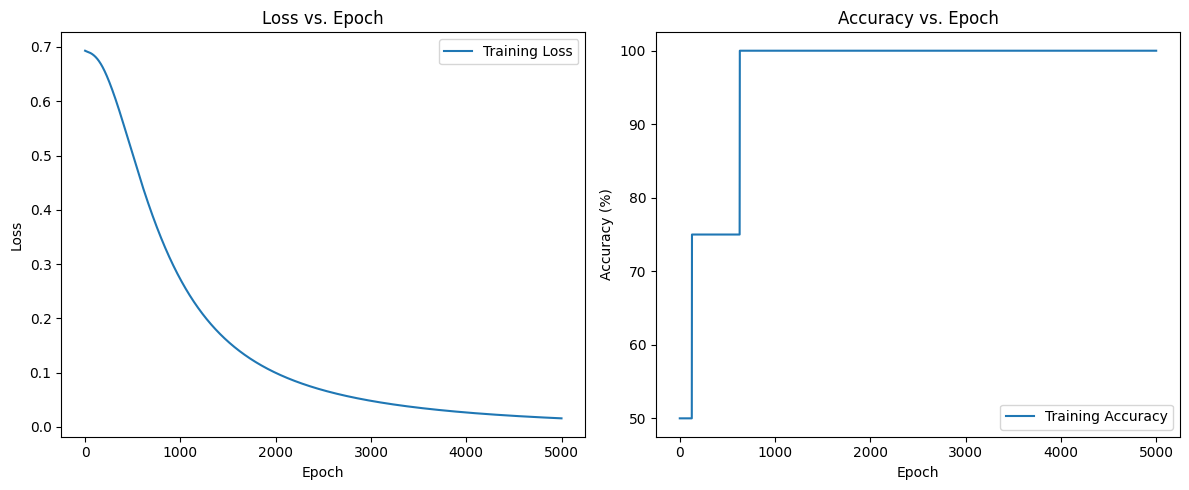

In [ ]:
# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(trained_metrics['losses'], label='Training Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(trained_metrics['accuracies'], label='Training Accuracy')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Save the weights and biases history to a file after training
with open('recurrent_weights_biases_history.pkl', 'wb') as file:
    pickle.dump(weights_and_biases_history, file)

print("Weights and biases history saved to recurrent_weights_biases_history.pkl")

Weights and biases history saved to recurrent_weights_biases_history.pkl


In [ ]:
# Final Test
with torch.no_grad():
    predictions = model(X)
    predictions = (predictions > 0.5).float()
    print("\nFinal Predictions:")
    print(predictions)

print("\nTraining completed and weights saved to 'xor_rnn_weights_biases.pth'.")


Final Predictions:
tensor([[0.],
        [1.],
        [1.],
        [0.]])

Training completed and weights saved to 'xor_rnn_weights_biases.pth'.


# Meta NN

In [ ]:
class MetaNN_RNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MetaNN_RNN, self).__init__()
        self.lstm = nn.LSTM(input_dim, 32, 4, batch_first=True)  # LSTM layers
        self.fc = nn.Linear(32, output_dim)  # Fully connected output layer

    def forward(self, x):
        out, (hidden, _) = self.lstm(x)  # Pass through LSTM layers

        # Use the last hidden state from LSTM
        # last_hidden = hidden[-1]  # Shape: [batch_size, hidden_dim]
        output = self.fc(out)  # Shape: [batch_size, output_dim]
        return output

In [ ]:
# Load the weights and biases history from the file
with open('recurrent_weights_biases_history.pkl', 'rb') as file:
    weights_and_biases_history = pickle.load(file)

print("Loaded weights and biases history successfully.")

Loaded weights and biases history successfully.


In [ ]:
weights_and_biases_history

[{'rnn_weight': array([[-0.00757271, -0.1660493 ,  0.44561344,  0.42990488],
         [-0.07242978, -0.05531126,  0.45277786,  0.36469465],
         [ 0.16539705, -0.19726753,  0.321728  ,  0.39106405],
         [ 0.20041972,  0.12196124, -0.24594414,  0.40123522]],
        dtype=float32),
  'rnn_bias': array([0.08648448, 0.12463078, 0.75112516, 0.47102147], dtype=float32),
  'fc_weight': array([[-1.686997 , -2.5475671, -4.204443 , -4.263211 ]], dtype=float32),
  'fc_bias': array([0.39225897], dtype=float32)},
 {'rnn_weight': array([[-0.00757271, -0.1660493 ,  0.44561344,  0.42990488],
         [-0.07242978, -0.05531126,  0.45277786,  0.36469465],
         [ 0.16539705, -0.19726753,  0.321728  ,  0.39106405],
         [ 0.20041972,  0.12196124, -0.24594414,  0.40123522]],
        dtype=float32),
  'rnn_bias': array([0.08648448, 0.12463078, 0.75112516, 0.47102147], dtype=float32),
  'fc_weight': array([[-1.686997 , -2.5475671, -4.204443 , -4.263211 ]], dtype=float32),
  'fc_bias': array

In [ ]:
# Prepare training data for MetaNN
input_data = []
target_data = []

for epoch_data in weights_and_biases_history:
    # Reduce hidden_weight and hidden_bias to two scalar values for input
    hidden_weight_mean = torch.tensor(epoch_data["rnn_weight"]).mean()  # Mean of hidden_weight
    hidden_bias_mean = torch.tensor(epoch_data["rnn_bias"]).mean()      # Mean of hidden_bias

    input_features = torch.tensor([hidden_weight_mean, hidden_bias_mean])  # Input size is 2
    input_data.append(input_features)

    # Targets: Flatten output weights and biases
    target_values = torch.cat([
        torch.tensor(epoch_data["fc_weight"]).view(-1),
        torch.tensor(epoch_data["fc_bias"]).view(-1)
    ])
    target_data.append(target_values)

# Convert to tensors for training
input_data = torch.stack(input_data)  # Shape: (num_epochs, hidden_dim)
target_data = torch.stack(target_data)  # Shape: (num_epochs, output_dim)

In [ ]:
print(f"Input data min: {input_data.min()}")
print(f"Input data min: {input_data.max()}")

Input data min: 0.15938882529735565
Input data min: 0.35831546783447266


In [ ]:
target_data

tensor([[-1.6870, -2.5476, -4.2044, -4.2632,  0.3923],
        [-1.6870, -2.5476, -4.2044, -4.2632,  0.3923],
        [-1.6870, -2.5476, -4.2044, -4.2632,  0.3923],
        ...,
        [-1.6870, -2.5476, -4.2044, -4.2632,  0.3923],
        [-1.6870, -2.5476, -4.2044, -4.2632,  0.3923],
        [-1.6870, -2.5476, -4.2044, -4.2632,  0.3923]])

In [ ]:
print(f"Target data min: {target_data.min()}")
print(f"Target data min: {target_data.max()}")

Target data min: -4.263210773468018
Target data min: 0.39225897192955017


In [ ]:
# Normalize target_data before training to range 0-1
data_min = torch.min(target_data)
data_max = torch.max(target_data)

# Handle zero range to avoid division by zero
range_ = data_max - data_min
target_data = torch.where(range_ == 0, torch.zeros_like(target_data), 2 * (target_data - data_min) / range_ - 1)

In [ ]:
data_min

tensor(-4.2632)

In [ ]:
print(f"Target data min: {target_data.min()}")
print(f"Target data min: {target_data.max()}")
print(f"Target data: {target_data}")

Target data min: -1.0
Target data min: 1.0
Target data: tensor([[ 0.1067, -0.2630, -0.9748, -1.0000,  1.0000],
        [ 0.1067, -0.2630, -0.9748, -1.0000,  1.0000],
        [ 0.1067, -0.2630, -0.9748, -1.0000,  1.0000],
        ...,
        [ 0.1067, -0.2630, -0.9748, -1.0000,  1.0000],
        [ 0.1067, -0.2630, -0.9748, -1.0000,  1.0000],
        [ 0.1067, -0.2630, -0.9748, -1.0000,  1.0000]])


In [ ]:
# Dataset Split Ratios
train_ratio = 0.7  # 70% training
val_ratio = 0.15   # 15% validation
test_ratio = 0.15  # 15% testing

# Calculate the split sizes
total_size = len(input_data)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(
    TensorDataset(input_data, target_data), [train_size, val_size, test_size]
)

In [ ]:
# Create DataLoaders for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=100)
test_loader = DataLoader(test_dataset, batch_size=100)

In [ ]:
# Initialize MetaNN_RNN
input_dim = input_data.size(1)  # Dimension of hidden weights + hidden biases
output_dim = target_data.size(1)  # Dimension of output weights + output biases
print(f"Input Dimension: {input_dim}, Output Dimension: {output_dim}")

Input Dimension: 2, Output Dimension: 5


In [ ]:
meta_model = MetaNN_RNN(input_dim, output_dim)

In [ ]:
out = meta_model(X)
out

tensor([[ 0.0709,  0.0428,  0.0392, -0.1660,  0.0512],
        [ 0.0671,  0.0381,  0.0361, -0.1649,  0.0687],
        [ 0.0618,  0.0336,  0.0327, -0.1643,  0.0783],
        [ 0.0571,  0.0296,  0.0303, -0.1640,  0.0832]],
       grad_fn=<AddmmBackward0>)

In [ ]:
out.size()

torch.Size([4, 5])

## Train MetaNN using the weights and biases of Model 1

In [ ]:
# Define Loss Function and Optimizer for MetaNN
criterion_meta = nn.MSELoss()
meta_optimizer = optim.Adam(meta_model.parameters(), lr=0.0000001)

meta_losses = []   # Store training losses
meta_val_losses = []  # Store validation losses

# Training Loop for MetaNN
epochs_meta = 10000  # Number of training epochs

# Training Loop with validation
for epoch in range(epochs_meta):
    meta_model.train()  # Set model to training mode
    epoch_loss = 0.0
    total_batches = 0

    for inputs, targets in train_loader:
        outputs = meta_model(inputs)
        loss_meta = criterion_meta(outputs, targets)
        total_batches += 1
        # Backpropagation and optimization
        meta_optimizer.zero_grad()
        loss_meta.backward()
        meta_optimizer.step()

        epoch_loss += loss_meta.item()

    avg_loss = epoch_loss / total_batches
    meta_losses.append(avg_loss)

    # Validation phase
    meta_model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_outputs = meta_model(val_inputs)
            loss_val = criterion_meta(val_outputs, val_targets)
            val_loss += loss_val.item()

    avg_val_loss = val_loss / len(val_loader)
    meta_val_losses.append(avg_val_loss)

    # Print epoch metrics
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{epochs_meta}], Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

print("MetaNN training completed.")


Epoch [100/10000], Loss: 0.5201, Val Loss: 0.5202
Epoch [200/10000], Loss: 0.5150, Val Loss: 0.5151
Epoch [300/10000], Loss: 0.5098, Val Loss: 0.5099
Epoch [400/10000], Loss: 0.5046, Val Loss: 0.5047
Epoch [500/10000], Loss: 0.4994, Val Loss: 0.4995
Epoch [600/10000], Loss: 0.4941, Val Loss: 0.4943
Epoch [700/10000], Loss: 0.4888, Val Loss: 0.4889
Epoch [800/10000], Loss: 0.4834, Val Loss: 0.4836
Epoch [900/10000], Loss: 0.4780, Val Loss: 0.4782
Epoch [1000/10000], Loss: 0.4725, Val Loss: 0.4727
Epoch [1100/10000], Loss: 0.4669, Val Loss: 0.4671
Epoch [1200/10000], Loss: 0.4613, Val Loss: 0.4615
Epoch [1300/10000], Loss: 0.4556, Val Loss: 0.4559
Epoch [1400/10000], Loss: 0.4499, Val Loss: 0.4501
Epoch [1500/10000], Loss: 0.4440, Val Loss: 0.4443
Epoch [1600/10000], Loss: 0.4381, Val Loss: 0.4384
Epoch [1700/10000], Loss: 0.4320, Val Loss: 0.4324
Epoch [1800/10000], Loss: 0.4259, Val Loss: 0.4262
Epoch [1900/10000], Loss: 0.4196, Val Loss: 0.4200
Epoch [2000/10000], Loss: 0.4132, Val Lo

In [ ]:
# Test the trained MetaNN
with torch.no_grad():
    final_meta_output = meta_model(input_data)
    print("\nFinal MetaNN Output:")
    print(final_meta_output)


Final MetaNN Output:
tensor([[ 0.0909, -0.0166, -0.1219, -0.3124,  0.2057],
        [ 0.0930, -0.0800, -0.3066, -0.4572,  0.3842],
        [ 0.0906, -0.1418, -0.4996, -0.6089,  0.5627],
        ...,
        [ 0.1074, -0.2655, -0.9819, -1.0070,  1.0076],
        [ 0.1074, -0.2655, -0.9819, -1.0070,  1.0076],
        [ 0.1074, -0.2655, -0.9819, -1.0070,  1.0076]])


In [ ]:
# @title Meta NN Evaluation

# Test the trained MetaNN
with torch.no_grad():
    # Final accuracy based on the last epoch
    final_loss_last_epoch = meta_losses[-1]  # Accuracy from the last epoch

    print(f"\nFinal loss: \t\t {final_loss_last_epoch:.4f}")

# Testing the model using the validation data
meta_model.eval()
val_loss = 0.0
with torch.no_grad():
    for val_inputs, val_targets in val_loader:
        val_outputs = meta_model(val_inputs)
        loss_val = criterion_meta(val_outputs, val_targets)
        val_loss += loss_val.item()

avg_val_loss = val_loss / len(val_loader)
print(f"Final val Loss: \t {avg_val_loss:.4f}")

# Testing the model using the test data
test_loss = 0.0
with torch.no_grad():
    for test_inputs, test_targets in test_loader:
        test_outputs = meta_model(test_inputs)
        loss_test = criterion_meta(test_outputs, test_targets)
        test_loss += loss_test.item()

avg_test_loss = test_loss / len(test_loader)
print(f"Final Test Loss: \t {avg_test_loss:.4f}")


Final loss: 		 0.0081
Final val Loss: 	 0.0091
Final Test Loss: 	 0.0091


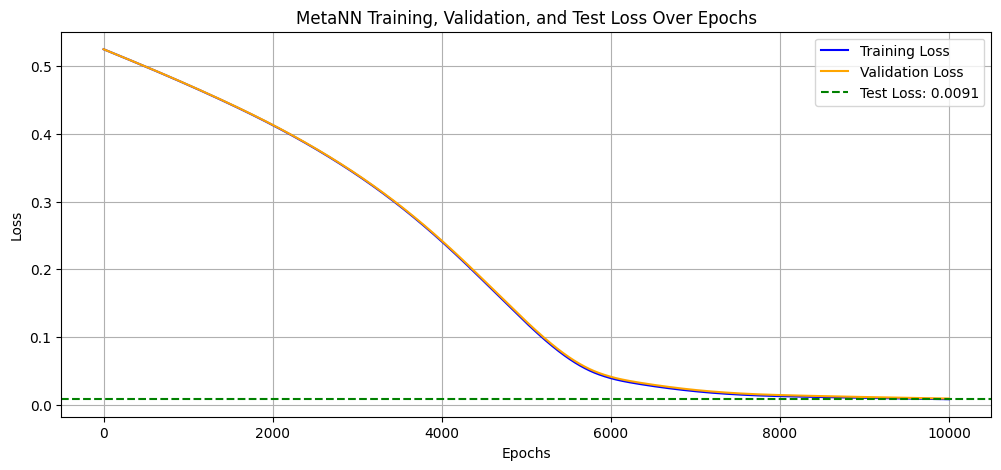

In [ ]:
# Plot loss over epochs for MetaNN
plt.figure(figsize=(12, 5))

# Subplot for training and validation losses
plt.plot(range(epochs_meta), meta_losses, label='Training Loss', color='blue')
plt.plot(range(epochs_meta), meta_val_losses, label='Validation Loss', color='orange')

# Plot test loss as a horizontal line
plt.axhline(y=avg_test_loss, color='green', linestyle='--', label=f'Test Loss: {avg_test_loss:.4f}')

# Labeling and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MetaNN Training, Validation, and Test Loss Over Epochs')
plt.legend()
plt.grid(True)

plt.show()


# Model 2

In [ ]:
# Save the trained MetaNN
torch.save(meta_model.state_dict(), 'meta_nn_recurrent.pth')
print("MetaNN recurrent saved successfully.")

MetaNN recurrent saved successfully.


In [ ]:
# Define a new ANN model for Model_2

class Model_2(nn.Module):
    def __init__(self):
        super(Model_2, self).__init__()
        self.hidden = nn.Linear(2, 4)  # Input layer to hidden layer (4 neurons)
        self.output = nn.Linear(4, 1)  # Hidden layer to output layer (1 neuron)
        # nn.init.xavier_uniform_(self.hidden.weight)  # Xavier/Glorot initialization for better training
        # nn.init.xavier_uniform_(self.output.weight)

    def forward(self, x):
        x = torch.relu(self.hidden(x))  # Hidden layer with ReLU activation
        x = torch.sigmoid(self.output(x))  # Output layer with Sigmoid activation
        return x


In [ ]:
meta_updates = meta_model(X)
meta_updates

tensor([[ 0.0909, -0.0164, -0.1209, -0.3118,  0.2049],
        [ 0.0930, -0.0797, -0.3055, -0.4564,  0.3832],
        [ 0.0906, -0.1417, -0.4990, -0.6084,  0.5622],
        [ 0.0904, -0.1902, -0.6666, -0.7403,  0.7145]],
       grad_fn=<AddmmBackward0>)

In [ ]:
target_net = Model_2()
outputs = target_net(X)
outputs

tensor([[0.4753],
        [0.5310],
        [0.4760],
        [0.5292]], grad_fn=<SigmoidBackward0>)

## Train Model 2 using MetaNN

In [ ]:
# Define training parameters
epochs = 100000
learning_rate = 0.0001
momentum = 0.9
weight_decay = 0.000001
gamma = 0.8  # Learning rate decay factor
clip_value = 0.9  # Gradient clipping threshold


def train_target_network_with_meta_nn(meta_model, target_net, target_loader, epochs, momentum, learning_rate, weight_decay, gamma, clip_value, patience=20):

    prev_update = None
    optimizer = optim.Adam(target_net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=gamma)

    # Initialize placeholders for metrics
    trained_losses = []
    trained_accuracies = []
    epoch_counter = 0

    # Early stopping variables
    best_loss = float('inf')
    patience_counter = 0  # Counter for early stopping

    # Training loop for Model_2 using MetaNN-generated updates
    for epoch in range(epochs):
        epoch_counter += 1
        epoch_loss = 0.0
        correct = 0
        total = 0

        for inputs, targets in target_loader:
            # Forward pass of Model_2
            outputs = target_net(inputs)
            criterion = nn.MSELoss()
            loss = criterion(outputs, targets)

            # Generate updates with MetaNN based on inputs
            meta_updates = meta_model(inputs)
            meta_updates = torch.clamp(meta_updates, -clip_value, clip_value)  # Clip updates

            # Apply MetaNN-generated updates to Model_2
            with torch.no_grad():
              weight_update_index = 0  # Initialize an index for tracking updates within meta_updates

              for name, param in target_net.named_parameters():
                  # Determine the number of elements in the current parameter
                  num_elements = param.numel()  # Total number of elements in this parameter

                  # Extract the corresponding updates from meta_updates
                  param_updates = meta_updates.view(-1)[weight_update_index:weight_update_index + num_elements]
                  # Reshape updates to match the parameter's shape
                  param_updates = param_updates.view(param.size())

                  # Apply the updates to the parameter
                  param.add_(learning_rate * param_updates)

                  # Move the index forward by the number of elements processed
                  weight_update_index += num_elements

            # Accumulate batch loss
            epoch_loss += loss.item()

            # Calculate accuracy for this batch
            predicted = (outputs > 0.5).float()  # Convert probabilities to binary (0 or 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

        # Calculate and store average loss and accuracy for this epoch
        avg_loss = epoch_loss / len(target_loader)
        accuracy = 100 * correct / total
        trained_losses.append(avg_loss)
        trained_accuracies.append(accuracy)



        # Print epoch metrics for monitoring
        if (epoch + 1) % 1000 == 0:
            print(f"\n\nEpoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
            predictions = target_net(X)
            # predictions = (predictions > 0.5).float()
            print("Predictions:")
            print(predictions.flatten())
            # Early stopping: Check for improvement
            if avg_loss < best_loss:
                best_loss = avg_loss
                patience_counter = 0  # Reset patience counter
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered at epoch {epoch + 1}")
                    break

    print("Model_2 training with MetaNN completed.")
    return trained_losses, trained_accuracies, epoch_counter



In [ ]:
# Plotting function

def plot_training_progress(losses, accuracies, epoch_counter):
  # Plot Loss
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(range(epoch_counter), trained_losses, label='Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Model_2 Training Loss Over Epochs')
  plt.legend()

  # Plot Accuracy
  plt.subplot(1, 2, 2)
  plt.plot(range(epoch_counter), trained_accuracies, label='Accuracy', color='orange')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy (%)')
  plt.title('Model_2 Training Accuracy Over Epochs')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
# Training and plotting
X = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
y = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)
batch_size = 60
dataset = TensorDataset(X, y)
data_loader = DataLoader(dataset, batch_size=batch_size)


In [ ]:
# Initialize MetaNN and load the saved state dictionary
meta_model = MetaNN_RNN(2,5)
meta_model.load_state_dict(torch.load('meta_nn_recurrent.pth'))
meta_model.eval()  # Set MetaNN to evaluation mode if not training it further
print("MetaNN loaded successfully.")


MetaNN loaded successfully.


<ipython-input-35-51bfdeb6791d>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta_model.load_state_dict(torch.load('meta_nn_recurrent.pth'))


In [ ]:
model_2 = Model_2()

In [ ]:
trained_losses, trained_accuracies, epoch_counter = train_target_network_with_meta_nn(
    meta_model=meta_model,
    target_net=model_2,
    target_loader=data_loader,
    epochs=epochs,
    momentum=momentum,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    gamma=gamma,
    clip_value=clip_value,
)



Epoch [1000/100000], Loss: 0.2581, Accuracy: 50.00%
Predictions:
tensor([0.4313, 0.4595, 0.4115, 0.4560], grad_fn=<ViewBackward0>)


Epoch [2000/100000], Loss: 0.2632, Accuracy: 50.00%
Predictions:
tensor([0.4184, 0.4272, 0.3935, 0.4263], grad_fn=<ViewBackward0>)


Epoch [3000/100000], Loss: 0.2692, Accuracy: 50.00%
Predictions:
tensor([0.4043, 0.3964, 0.3749, 0.3980], grad_fn=<ViewBackward0>)


Epoch [4000/100000], Loss: 0.2761, Accuracy: 50.00%
Predictions:
tensor([0.3893, 0.3673, 0.3559, 0.3711], grad_fn=<ViewBackward0>)


Epoch [5000/100000], Loss: 0.2837, Accuracy: 50.00%
Predictions:
tensor([0.3733, 0.3400, 0.3365, 0.3458], grad_fn=<ViewBackward0>)


Epoch [6000/100000], Loss: 0.2918, Accuracy: 50.00%
Predictions:
tensor([0.3564, 0.3146, 0.3169, 0.3221], grad_fn=<ViewBackward0>)


Epoch [7000/100000], Loss: 0.3003, Accuracy: 50.00%
Predictions:
tensor([0.3388, 0.2910, 0.2971, 0.2995], grad_fn=<ViewBackward0>)


Epoch [8000/100000], Loss: 0.3085, Accuracy: 50.00%
Predictions:
te

In [ ]:
# Testing the model
with torch.no_grad():
    predictions = model_2(X)
    predictions = (predictions > 0.5).float()  # Convert probabilities to binary output
    print("\nPredictions:")
    print(predictions)


Predictions:
tensor([[0.],
        [0.],
        [0.],
        [0.]])


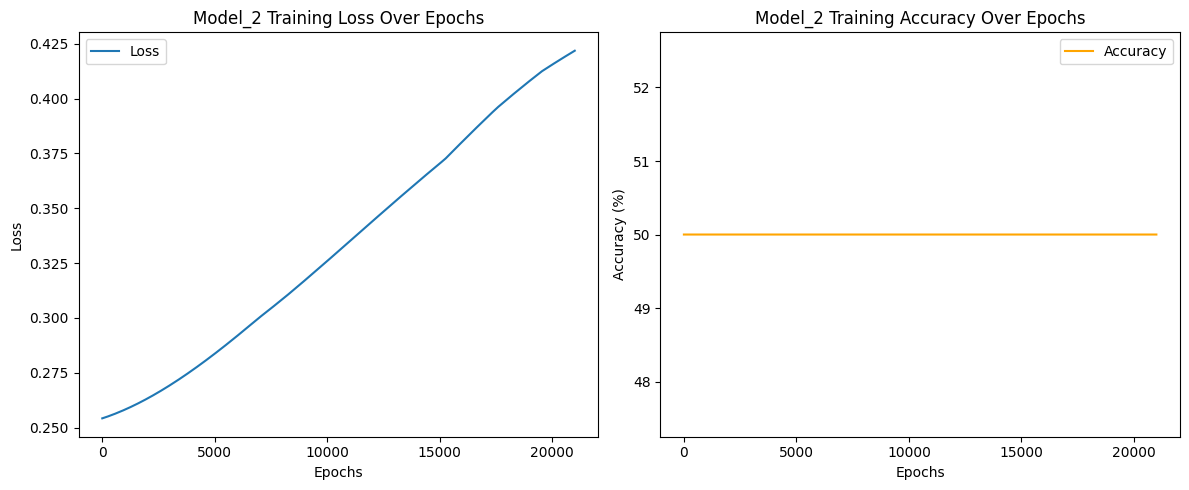

In [ ]:
# Plot the training loss and accuracy
plot_training_progress(trained_losses, trained_accuracies, epoch_counter)

In [ ]:
# Save the trained MetaNN
torch.save(model_2.state_dict(), 'model_trained_by_Meta.pth')
print("model_trained_by_Meta saved successfully.")


model_trained_by_Meta saved successfully.
